In [1]:
import numpy as np
from utils import *

### Read Subject and Data Preprocessing

In [51]:
path = "data/Jeonghan Yoga/Novices/N001/Revolved_Triangle.csv"
cop, grf, marker_clouds = load_data_jeonghan(path)
cop = lowpass_filter(cop, cutoff_freq=2, fs=2000)
grf = lowpass_filter(grf, cutoff_freq=10, fs=2000)
for i in range(marker_clouds.shape[1]):
    marker_clouds[:,i, 0] = lowpass_filter(marker_clouds[:,i, 0], cutoff_freq=20, fs=100)
    marker_clouds[:,i, 1] = lowpass_filter(marker_clouds[:,i, 1], cutoff_freq=20, fs=100)
    marker_clouds[:,i, 2] = lowpass_filter(marker_clouds[:,i, 2], cutoff_freq=20, fs=100)

com = np.nanmean(marker_clouds[:,:8,:], axis=1)
subject_mass = 56 # kg

subject_name = "N001"
subject_pose = "Revolved_Triangle"

/home/darren/Desktop/grf_estimation/utils.py:85: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175) have mixed types. Specify dtype option on import or set low_memory=False.
  yoga_data = pd.read_csv(csv_path, skiprows=5)


## Visualize Data
### Vertical Ground Reaction Force

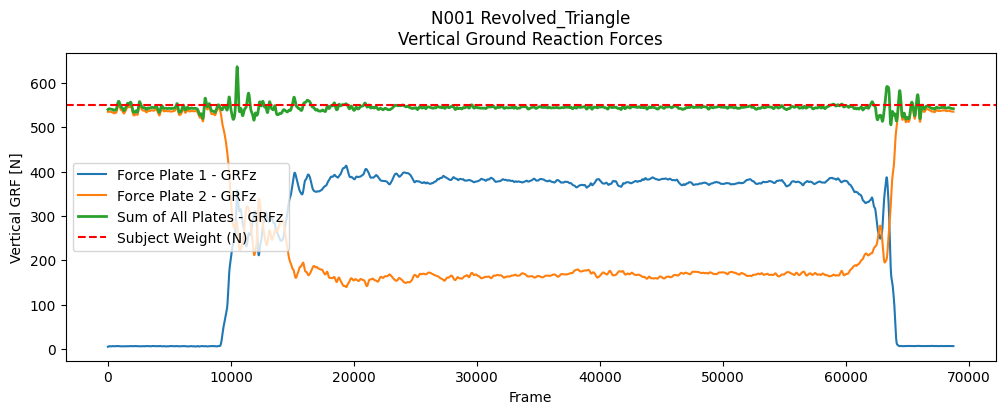

In [52]:
import matplotlib.pyplot as plt

# Plot the vertical GRF (z-component) for both force plates
plt.figure(figsize=(12, 4))
for plate in range(grf.shape[1]):
    plt.plot(grf[:, plate, 2], label=f'Force Plate {plate+1} - GRFz')
plt.plot(np.sum(grf[:, :, 2], axis=1), label='Sum of All Plates - GRFz', linewidth=2)
plt.axhline(subject_mass * 9.81, color='red', linestyle='--', label='Subject Weight (N)')
plt.xlabel('Frame')
plt.ylabel('Vertical GRF [N]')
plt.title(f'{subject_name} {subject_pose}\nVertical Ground Reaction Forces')
plt.legend()
plt.show()

### Finite Differenced COM Dynamics

In [53]:
com_accel = np.zeros_like(com)
dt_markers = 100 # 100 Hz for marker data
# Calculate velocity using central differences
com_vel = np.zeros_like(com)
com_vel[1:-1] = (com[2:] - com[:-2]) / (2*dt_markers)

# Calculate acceleration using central differences
com_accel[1:-1] = (com[2:] - 2 * com[1:-1] + com[:-2]) / (dt_markers**2)


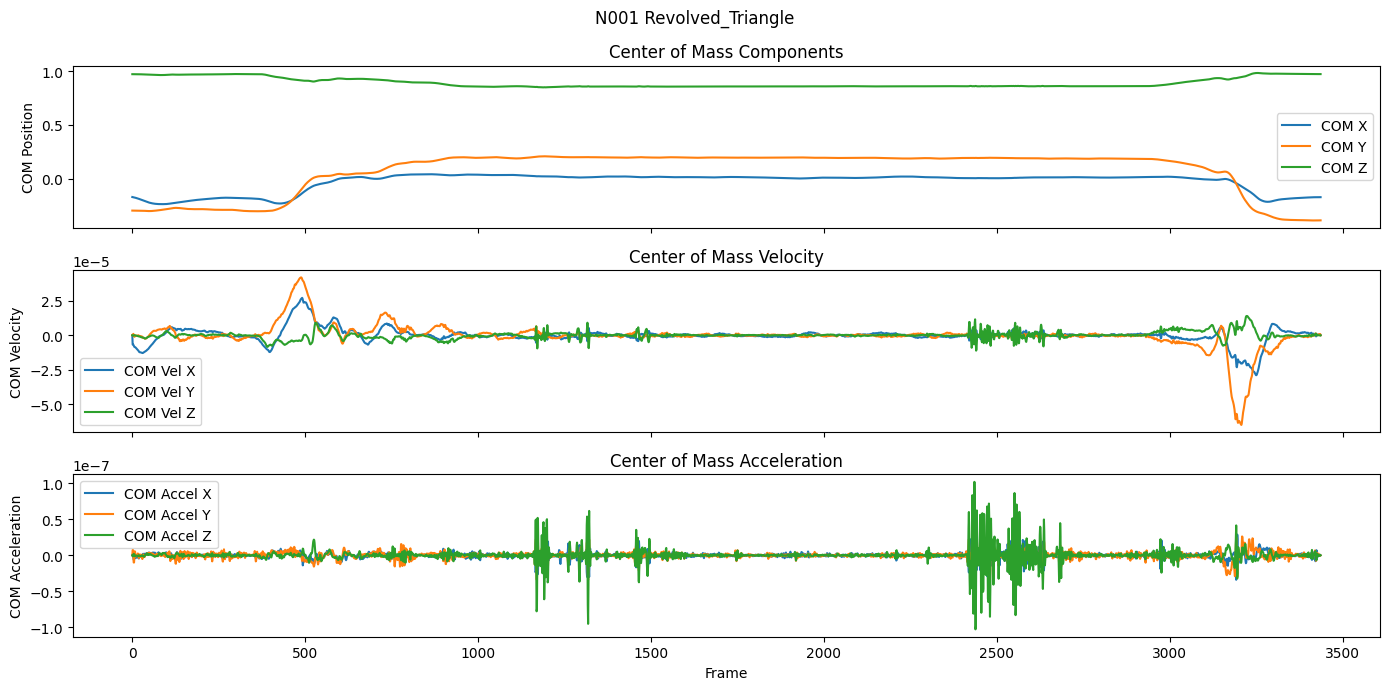

In [54]:
fig, axs = plt.subplots(3, 1, figsize=(14, 7), sharex=True)
fig.suptitle(f'{subject_name} {subject_pose}')
# COM position
axs[0].plot(com[:, 0], label='COM X')
axs[0].plot(com[:, 1], label='COM Y')
axs[0].plot(com[:, 2], label='COM Z')
axs[0].set_ylabel('COM Position')
axs[0].set_title('Center of Mass Components')
axs[0].legend()

# COM velocity
axs[1].plot(com_vel[:, 0], label='COM Vel X')
axs[1].plot(com_vel[:, 1], label='COM Vel Y')
axs[1].plot(com_vel[:, 2], label='COM Vel Z')
axs[1].set_ylabel('COM Velocity')
axs[1].set_title('Center of Mass Velocity')
axs[1].legend()

# COM acceleration
axs[2].plot(com_accel[:, 0], label='COM Accel X')
axs[2].plot(com_accel[:, 1], label='COM Accel Y')
axs[2].plot(com_accel[:, 2], label='COM Accel Z')
axs[2].set_xlabel('Frame')
axs[2].set_ylabel('COM Acceleration')
axs[2].set_title('Center of Mass Acceleration')
axs[2].legend()

plt.tight_layout()
plt.show()

### Compare Marker COM Acceleration and Force Plate Predicted Acceleration

In [30]:
num_marker_frames = marker_clouds.shape[0]
num_grf_frames = grf.shape[0]
# Downsample cop and grf to match the number of frames in marker_clouds
com_accel_FP = np.zeros((num_grf_frames, 3))
if num_grf_frames > num_marker_frames:
    # Calculate the downsampling ratio
    ratio = float(num_grf_frames) / float(num_marker_frames)
    # Create indices for downsampling
    indices = np.arange(num_marker_frames) * ratio
    indices = np.round(indices).astype(int)
    # Downsample the data
    com_accel_FP = np.sum(grf[indices], axis=1)/subject_mass - np.array([0, 0, 9.81])

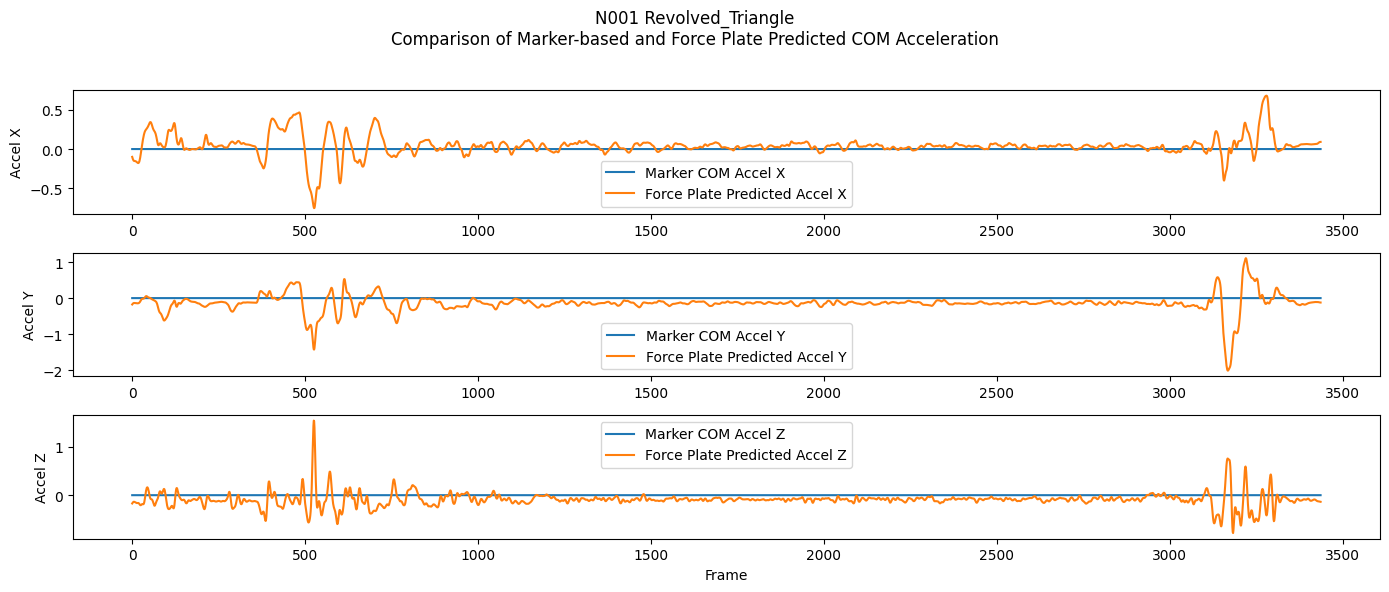

In [46]:
plt.figure(figsize=(14, 6))
labels = ['X', 'Y', 'Z']
for j in range(3):
    plt.subplot(3, 1, j+1)
    plt.plot(com_accel[:, j], label='Marker COM Accel ' + labels[j])
    plt.plot(com_accel_FP[:, j], label='Force Plate Predicted Accel ' + labels[j])
    plt.ylabel(f'Accel {labels[j]}')
    plt.legend()
plt.xlabel('Frame')
plt.suptitle(f'{subject_name} {subject_pose}\nComparison of Marker-based and Force Plate Predicted COM Acceleration')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()